# Project 2

In [1]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)

import warnings
#Comment this to turn on warnings
warnings.filterwarnings('ignore')

from utils import generateDesignmatrix
from model_comparison import model_comparison
import algorithms
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn
%matplotlib inline

Calculating the coupeling coefficient J. 

Want to predict the energy with E = X*J

In [2]:
### define Ising model aprams
# system size
L=40

# create 10000 random Ising states
states=np.random.choice([-1, 1], size=(10000,L))

def ising_energies(states,L):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    """
    J=np.zeros((L,L),)
    for i in range(L):
        J[i,(i+1)%L]-=1.0
    # compute energies
    E = np.einsum('...i,ij,...j->...',states,J,states)

    return E
# calculate Ising energies
energies=ising_energies(states,L)

"""
Comparing to project 1 - x = states, z = energies... 
Currently no y since we are in one dimension. 

"""

'\nComparing to project 1 - x = states, z = energies... \nCurrently no y since we are in one dimension. \n\n'

In [3]:
states.shape

(10000, 40)

In [4]:
energies.shape

(10000,)

## OBS OBS copy

In [5]:
# reshape Ising states into RL samples: S_iS_j --> X_p
states=np.einsum('...i,...j->...ij', states, states)
shape=states.shape
states=states.reshape((shape[0],shape[1]*shape[2])) 
# build final data set
Data=[states,energies]

# define number of samples
n_samples=400
# define train and test data sets
X_train=Data[0][:n_samples]
Y_train=Data[1][:n_samples] #+ np.random.normal(0,4.0,size=X_train.shape[0])
X_test=Data[0][n_samples:3*n_samples//2]
Y_test=Data[1][n_samples:3*n_samples//2] #+ np.random.normal(0,4.0,size=X_test.shape[0])

In [6]:
# The above example splits before the regression. 
X = Data[0]
Y = Data[1]

# Regression analysis - part b)

In [7]:
# Experimental setup
models = {
    "ols": algorithms.OLS,
    #"ols": LinearRegression,
    'ridge': algorithms.Ridge, 
    "lasso": algorithms.Lasso
}
param_grid = {
    'ols': [0],
    'ridge': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100],  
    'lasso': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100]
}


# Might be a good idea to update if split_size = 0 --> do fit and predict on testdata only.
results, z_pred_best, coeffs = model_comparison(
    models, param_grid, X_train, Y_train, split_size=0.2
    )

Testing model: ols
Testing model: ridge
Testing model: lasso
1


In [8]:
#results

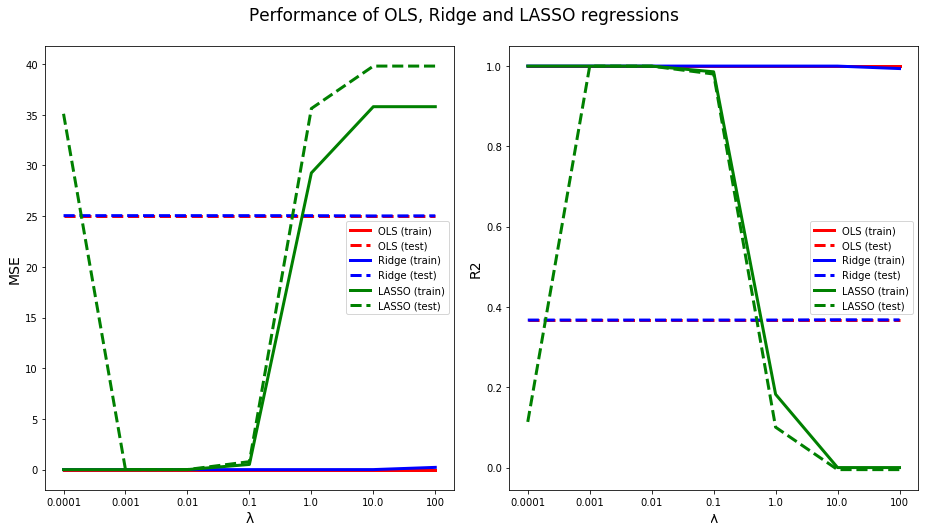

In [9]:
# Generate figure

# MSE
plt.figure(1, figsize = (13,7))
plt.subplot(1,2,1)
xlogr = np.log10(param_grid['ridge'])  # log x-axis
plt.plot(xlogr, (results["mse_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["mse_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)',  linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["mse_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.legend()

# R-squared
plt.subplot(1,2,2)
plt.plot(xlogr, (results["r2_train"]["ols"]*np.ones(len(xlogr))).T, 'r', label='OLS (train)', linewidth=3.0) 
plt.plot(xlogr, (results["r2_test"]["ols"]*np.ones(len(xlogr))).T, 'r--', label='OLS (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["ridge"]).T, 'b', label='Ridge (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["ridge"]).T, 'b--', label='Ridge (test)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_train"]["lasso"]).T, 'g', label='LASSO (train)', linewidth=3.0) 
plt.plot(xlogr, np.asarray(results["r2_test"]["lasso"]).T, 'g--', label='LASSO (test)', linewidth=3.0) 
ax = plt.gca()
plt.xticks(np.asarray(xlogr))
ax.set_xticklabels(param_grid['ridge'])
plt.xlabel('λ', fontsize=14)
plt.ylabel('R2', fontsize=14)
plt.legend()
plt.suptitle("Performance of OLS, Ridge and LASSO regressions", y=1.05, fontsize=17)
plt.savefig("results/figures/metric_regression_on_allData.png")
plt.tight_layout()    
plt.show()

If we use the same dataset as metha et al we get the same figure. Use X:train and Y_train. 
Our code split the data into train and test and then we use this to choose a model. This is why we don't 

# Plotting the coefficient of regression which is the coupling coefficient J

* Need to get olscoeff.reshape((40,40))
* Need to get the betas as output.

In [10]:
J_ols = coeffs["ols"][0][0].reshape((40,40))
J_ridge = np.array(coeffs["ridge"][0][0]).reshape((40,40))
J_lasso = coeffs["lasso"][0][0].reshape((40,40))

In [11]:
np.shape(coeffs["ridge"])
lmbda = param_grid["ridge"]
idx_lmd = 1
J_ridge = coeffs["ridge"][0][idx_lmd].reshape((40,40))

## I propose to only have the below plot for the best lmd -- Paulina?

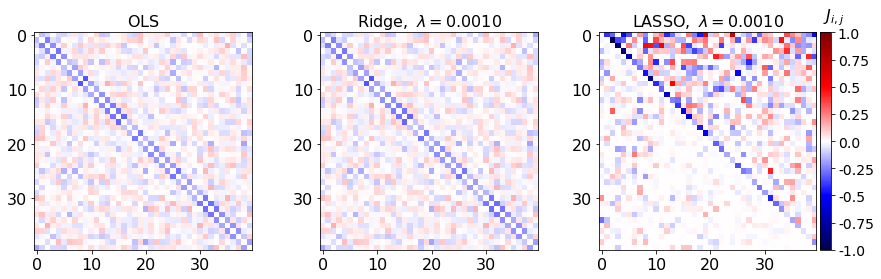

In [12]:
cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(J_ols,**cmap_args)
axarr[0].set_title('$\\mathrm{OLS}$',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(J_ridge,**cmap_args)
axarr[1].set_title('$\\mathrm{Ridge}, \ \\lambda= %.4f$' %(lmbda[1]),fontsize=16) # %(lmbda)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow(J_lasso,**cmap_args)
axarr[2].set_title('$\\mathrm{LASSO},\ \\lambda=%.4f $' %(lmbda[1]) ,fontsize=16) #%(lmbda)
axarr[2].tick_params(labelsize=16)

divider = make_axes_locatable(axarr[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar=fig.colorbar(im, cax=cax)

cbar.ax.set_yticklabels(np.arange(-1.0, 1.0+0.25, 0.25),fontsize=14)
cbar.set_label('$J_{i,j}$',labelpad=-40, y=1.12,fontsize=16,rotation=0)
fig.subplots_adjust(right=2.0)
plt.savefig("./results/figures/best_lambdas_one_dim.png")
plt.show()

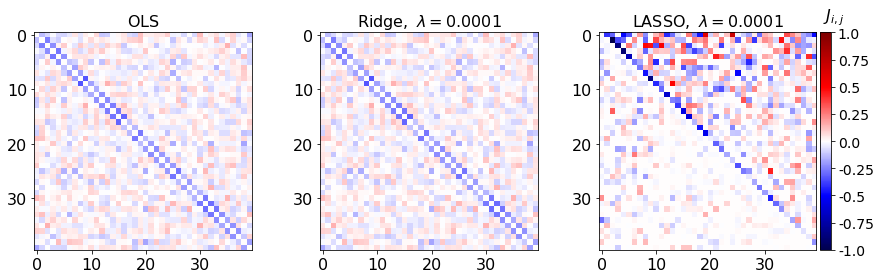

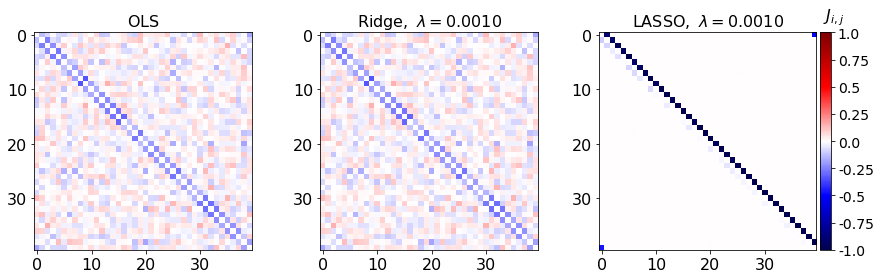

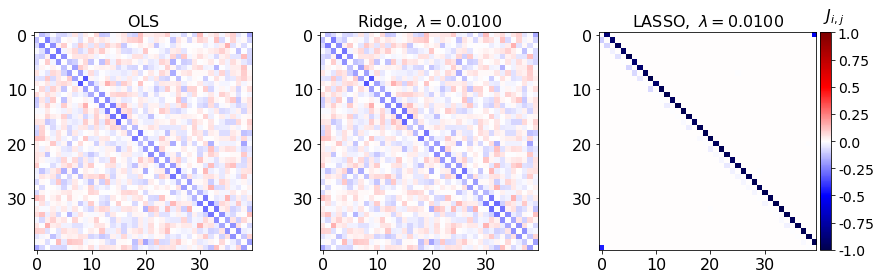

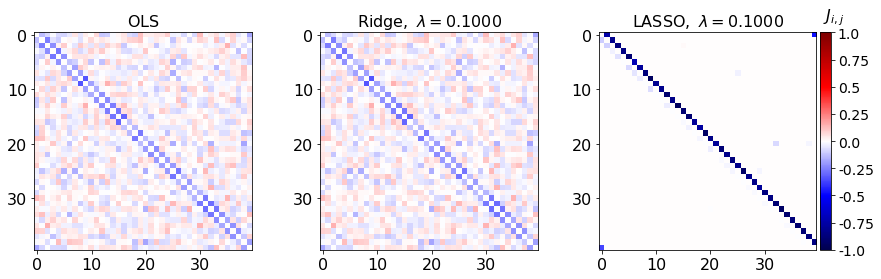

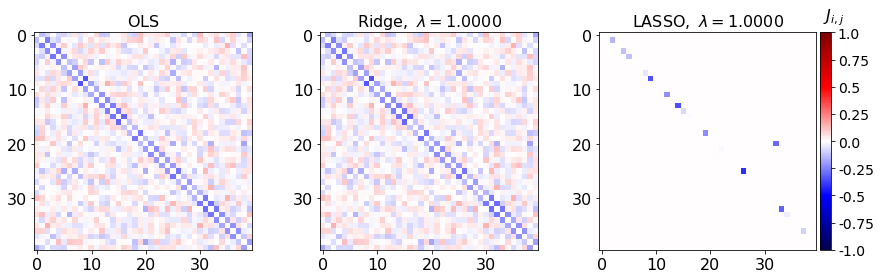

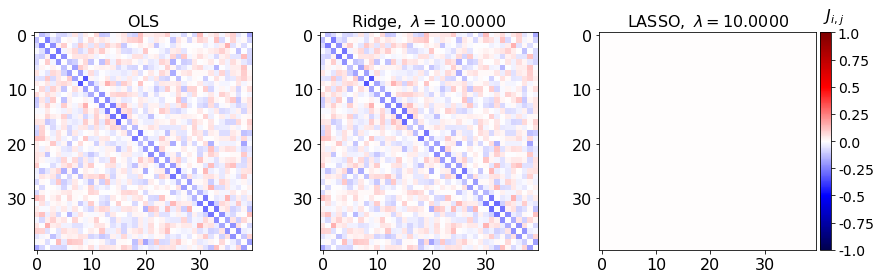

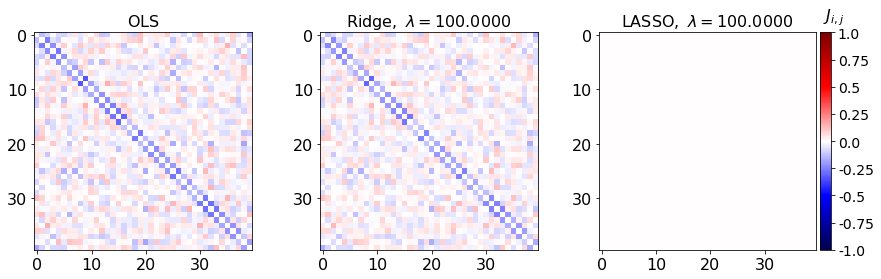

In [17]:
cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')
counter = 0
for lmd in lmbda:
    fig, axarr = plt.subplots(nrows=1, ncols=3)
    
    J_ols = coeffs["ols"][0][0].reshape((40,40))
    J_ridge = np.array(coeffs["ridge"][0][counter]).reshape((40,40))
    J_lasso = coeffs["lasso"][0][counter].reshape((40,40))
    
    counter += 1
    
    axarr[0].imshow(J_ols,**cmap_args)
    axarr[0].set_title('$\\mathrm{OLS}$',fontsize=16)
    axarr[0].tick_params(labelsize=16)

    axarr[1].imshow(J_ridge,**cmap_args)
    axarr[1].set_title('$\\mathrm{Ridge}, \ \\lambda= %.4f$' %(lmd),fontsize=16) # %(lmbda)
    axarr[1].tick_params(labelsize=16)

    im=axarr[2].imshow(J_lasso,**cmap_args)
    axarr[2].set_title('$\\mathrm{LASSO},\ \\lambda=%.4f $' %(lmd) ,fontsize=16) #%(lmbda)
    axarr[2].tick_params(labelsize=16)

    divider = make_axes_locatable(axarr[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(im, cax=cax)

    cbar.ax.set_yticklabels(np.arange(-1.0, 1.0+0.25, 0.25),fontsize=14)
    cbar.set_label('$J_{i,j}$',labelpad=-40, y=1.12,fontsize=16,rotation=0)
    fig.subplots_adjust(right=2.0)
    
fig.savefig("./results/figures/all_lambdas_one_dim.png")
plt.show()

## How come it only saves the first oneand a half square..?

# Creating svd -- cannot get it to work when we are using it inn 

In [ ]:
A = np.concatenate([[1,2,3], [9,7,2], [6,1,4]]).reshape((3, 3))

In [ ]:
#def svd(A):
" returns the singular value decomposition of a matrix A = U@D@V.T"
# calculate eigenvalues and eigenvectores.
nrows, ncols = np.shape(A)
u,V = np.linalg.eig(A.T@A)
# u is a vector of eigenvalues
# v is a vecort of eigenvectores.
s = np.sqrt(u) # singular values is the
D = np.identity(ncols)*s

print(D*s)

# D-1 is equal to 1/dii for all elements in D.
U = A@V@np.linalg.inv(D)
U, D, V

In [ ]:
U.T@U # identity

In [ ]:
V.T@V # this is close to the identity. 

In [ ]:
A

In [ ]:
U@D@V.T

In [ ]:
np.allclose(A,  U@D@V.T)

In [ ]:
D

# Part C)

In [ ]:
import pickle
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as skms
import sklearn.linear_model as skl
import sklearn.metrics as skm
import tqdm
import copy
import time
from IPython.display import display

%matplotlib inline

sns.set(color_codes=True)

In [ ]:
"""
filenames = glob.glob(os.path.join("..", "dat", "*"))
label_filename = list(filter(lambda x: "label" in x, filenames))[0]
dat_filename = list(filter(lambda x: "label" not in x, filenames))[0]

# Read in the labels
with open(label_filename, "rb") as f:
    labels = pickle.load(f)

# Read in the corresponding configurations
with open(dat_filename, "rb") as f:
    data = np.unpackbits(pickle.load(f)).reshape(-1, 1600).astype("int")

# Set spin-down to -1
data[data == 0] = -1
"""

In [ ]:
import pickle
import numpy as np
def read_t(t,root="./files/"):
    data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
    return np.unpackbits(data).astype(int).reshape(-1,1600)

### Excluding T = 2.0, 2.25, 2.5 because they are the critical phase and we have a binary model.

In [ ]:
t = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]

ordered = []
disordered = []

for t in t:
    if (t<2.0):
        ordered.append(read_t(t))
    else:
        disordered.append(read_t(t))

In [ ]:
np.shape(ordered)

In [ ]:
np.shape(disordered)

In [ ]:
# set spin-down to minus one. 
ordered[ordered == 0] = -1
disordered[disordered == 0] = -1

# now the spin has values either plus or minus one.

In [ ]:
# labels 

